Author: George Noble

Date: Sept 12, 2023

This program is an an example of a non-linear binary model


In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
!pip3 install git+https://github.com/PyTorchLightning/pytorch-lightning
#import pytorch_lightning as pl
#print(pl.__version__)

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-pqjr69az
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-pqjr69az
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit dbe7ed46a3554d7ff45a1f348b584aca6fa2d831
  Running command git submodule update --init --recursive -q
  Encountered 31 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebooks/course_UvA-DL/07-deep-energy-based-generative-models.ipynb
        .notebooks/course_UvA-DL/08-

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl

In [ ]:
print(pl.__version__)

2.1.0.rc0


In [ ]:
from typing_extensions import final
class FunProcessor:
    '''
    FunProcessor prepares the x values in binary format for input into the model

    1. Initialize x values in base 10
    2. Add noise to training  data
    3. Convert x values to Binary Format
    4. Initialize x values of train and valuation data
    5. For evaluating the model, x values may be given and no calculation is needed.

    '''
    #
    #
    def __init__(self, x_in, x_fin, dx, dxval):

        self.x_in = x_in
        self.x_fin = x_fin
        self.dx = dx

        self.x_train = np.arange(x_in, x_fin + dx, dx)
        x_val_in = x_in + dx/2
        x_val_fin = x_fin + dx/2
        self.x_val = np.arange(x_val_in, x_val_fin + dxval, dxval)
        print(self.x_train)
        print(self.x_val)
        self.y_train = 0


    # definition function of model.  In this case the function is a float at base 10.  In some cases this function is a given set of y(x) values were not
    # calculation is needed
    def create_y_fun (self, eq_n, x_range ):

        if eq_n == 1:
           y  = (x_range - 2) ** 3 + (x_range - 2)**2 + (x_range - 2) - 1

        return y

    # create function values
    def y_func(self, eq1, randFact):
        self.y_train = self.create_y_fun(eq1, self.x_train)
        random.seed(1)

        y_noise = 0.5 - np.random.rand(len(self.x_train))

        self.y_train = self.y_train + ( randFact * y_noise ) # dataset for training contains random elements

        self.y_val = self.create_y_fun(eq1, self.x_val) # dataset for val data contains no random elements

    # determined the max length of binary value for x
    def max_x(self, x_list):
        listy_x  = [bin(x)[2:] for x in x_list]
        max_len = 0
        for x in listy_x:
          ll =len(x)
          if max_len < ll:
            max_len = ll
            print(f"the max length in x1 is  {ll}")
        return  max_len, listy_x

    # Converting the x values to binary format.  This method allows for x values to have 5 decimal places
    def transform_x2Bin(self):
        x_train_round = self.x_train.round(decimals=4, out=None) * 10**4
        x_val_round = self.x_val.round(decimals=4, out=None) * 10**4
        self.x_train_round_int = x_train_round.astype(int)
        self.x_val_round_int = x_val_round.astype(int)
        max_len1, self.x_train_listy  = self.max_x(self.x_train_round_int)
        max_len2, self.x_val_listy = self.max_x(self.x_val_round_int)
        self.max_len = max(max_len1, max_len2)
        return self.max_len

    # plot the y-train versus x-train
    def plot_fun(self):
        plt.plot(self.x_train, self.y_train, 'r+', label = 'y_train')
        plt.xlabel('x_train')
        plt.ylabel('y_train')
        plt.legend()
        plt.show()


    # pad binary amounts to that x values have the same lenght
    def bit_convert(self, list1, max_len):
          list_num = '0'
          list_num1 = []
          final_list = []
          for x in list1:

            ll = len(x)
            if ll < max_len:
              for i in range(max_len - ll):

                x = list_num + x
              #print( x, len(x))
              if len(x) != max_len:
                print("problem")

            for string1 in x:
                if string1 == '0':
                  string1  = 0.0

                else:
                  string1 = 1.0

                list_num1.append(string1)
            #print(list_num1)
                #x = list_num1
            final_list.append(np.array(list_num1))
            list_num1 = []
          return(final_list)

    # converting function that controls the binary conversion.
    def convert_bin2float(self):
          fin_arr_x_train = np.array(self.bit_convert(self.x_train_listy, self.max_len))
          fin_arr_x_val = np.array(self.bit_convert(self.x_val_listy, self.max_len))
          return fin_arr_x_train, self.y_train, fin_arr_x_val, self.y_val


    # conversion for x data to binary for making inferencs on the model
    def transform_x2Bin_mod(self, x_model):
          expNo = 4
          x_model_round = x_model.round(decimals=expNo, out=None) * 10**expNo

          x_model_round_int = x_model_round.astype(int)

          max_len, x_model_listy  = self.max_x(x_model_round_int)

          if max_len > self.max_len:
            print("Value is to large")
            fin_arr_x_model = 0
          else:
            fin_arr_x_model = np.array(self.bit_convert(x_model_listy, self.max_len))

          return fin_arr_x_model


# Creating the training and val dataset for preperation of the building the model

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

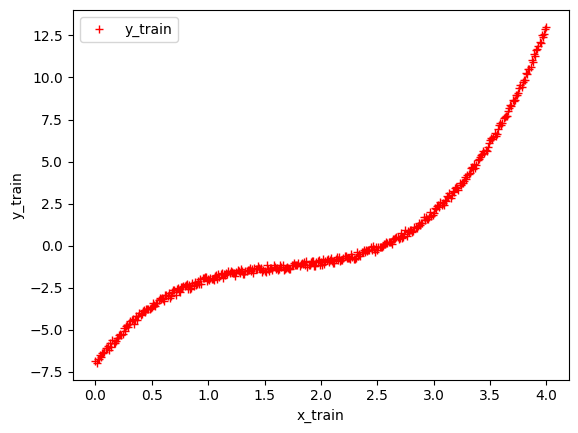

In [ ]:
test1 = FunProcessor(0.0, 4.0, 0.01, 0.1)
test1.y_func(eq1 = 1, randFact = 0.4)
max_len = test1.transform_x2Bin()
test1.plot_fun()
x_train, y_train, x_val, y_val = test1.convert_bin2float()

#Creating tensor based dataloaders

In [ ]:
tensor_x = torch.Tensor(x_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

tensor_x_val = torch.Tensor(x_val) # transform to torch tensor
tensor_y_val = torch.Tensor(y_val)

my_dataset_train = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader_train = DataLoader(my_dataset_train, batch_size=10) # create your dataloader

my_dataset_val = TensorDataset(tensor_x_val,tensor_y_val) # create your datset
my_dataloader_val = DataLoader(my_dataset_val, batch_size=10) # create your dataloader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Building the Model

In [ ]:
from torch import nn

import torch.nn.functional as F

from collections import OrderedDict
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class FunctionModel(pl.LightningModule):
  def __init__(self,learning_rate=1e-3, input_size = max_len, H1= 100, output_size = 1):
    super().__init__()
    self.learning_rate = learning_rate
    self.seq = nn.Sequential(nn.Linear(input_size, H1), nn.ReLU(), nn.Linear(H1, output_size) )


  def forward(self, x):
    return self.seq(x)

  def training_step(self, batch, batch_idx):
    binary, eval = batch
    x, y = binary, eval
    y= y.view(-1,1)
    y_hat = self(x)

    loss = F.l1_loss(y_hat, y)

    self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=False)
    return loss

  def validation_step(self, batch, batch_idx):
    binary, eval = batch
    x, y = binary, eval
    y= y.view(-1,1)
    y_hat = self(x)

    loss = F.l1_loss(y_hat, y)

    self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Building the Model

In [ ]:
from lightning.pytorch.loggers import CSVLogger

In [ ]:
logger = CSVLogger("lightning_logs", name="functionl", version="v1")

In [ ]:
train_dl = DataLoader(my_dataset_train, batch_size=5, shuffle=True)
val_dl = DataLoader(my_dataset_val, batch_size=5, shuffle=False)
trainer = pl.Trainer(check_val_every_n_epoch=1,  accelerator="auto",precision='16-mixed',max_epochs=100,strategy='auto', devices='auto', log_every_n_steps=10,logger=logger)
model = FunctionModel()
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:547: UserWarning: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.mo

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:448: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:448: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


#Building the Model Results

In [ ]:
path1 = "/content/lightning_logs/functionl/v1/metrics.csv"

,train_loss,val_loss
epoch,,
0,3.529275,NaN
0,5.206266,NaN
0,1.873112,NaN
0,2.872546,NaN
0,2.441587,NaN


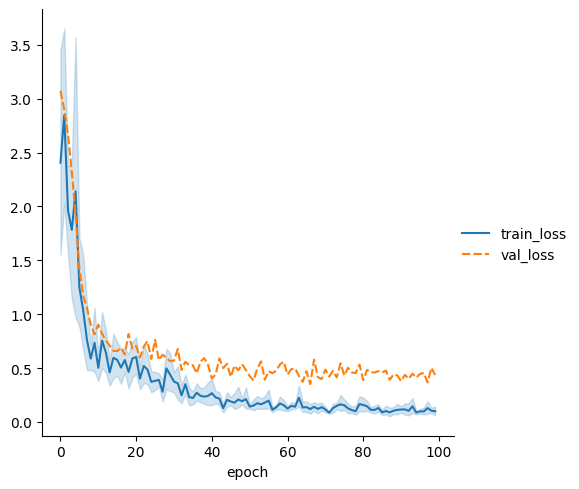

In [ ]:
metrics1 = pd.read_csv(path1)
del metrics1["step"]
metrics1.set_index("epoch", inplace=True)
display(metrics1.dropna(axis=1, how="all").head())
sn.relplot(data=metrics1, kind="line")

#Model Inference

In [ ]:
value = 5.1
float1_list = [value]
x_model = np.array(float1_list)
x_model_bin = np.array(test1.transform_x2Bin_mod(x_model))
print(x_model_bin)

the max length in x1 is  16
[[1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.]]


In [ ]:
tmp2 = torch.Tensor(x_model_bin)

#Saving Model

In [ ]:
path2 = "/content/nlModel"

In [ ]:
torch.save(model,path2) #Saving best model

#Loading Model

In [ ]:
model1 = torch.load(path2)
model1.eval() # set model for evalution
ratings = model1(tmp2)# assign model rating inference  ( stored in cpu with binary format tensor
ratings = ratings.detach().numpy()
ratings = ratings.flatten()
print(ratings)

Popularity Ratings
[6.133814]
